In [1]:
import numpy as np
import pandas as pd
import os
import pandas as pd
import sys

# Config

In [2]:
HYPER_OPT = True 
HYPER_OPT_TIME = 3600*5
USE_ORIGINAL_DATA = False 
SUBMIT_TO_KAGGLE = False

In [3]:
# Define the base directory (where the notebook is running)
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

# Define the data directory
data_dir = os.path.join(base_dir, "data")

model_dir = os.path.join(base_dir, "models")

sys.path.append(base_dir)

# Data Extraction

In [4]:
from axyom_utilities.data_extraction import extract_data

X_train, y_train, X_test, X_orig, y_orig = extract_data(data_dir, USE_ORIGINAL_DATA)

# Data Cleaning

In [5]:
from axyom_utilities.preprocessing import preprocess 

X_train = preprocess(X_train)
X_test = preprocess(X_test)
if USE_ORIGINAL_DATA:
    X_orig = preprocess(X_orig)

# HyperOpt

c:\Users\Axyom\anaconda3\envs\kaggle_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-11 18:51:58,769] Using an existing study with name 'Catboost_v1' instead of creating a new one.


Training fold 1...
Fold 1 RMSE: 1.0475
Training fold 2...
Fold 2 RMSE: 1.0465
Training fold 3...
Fold 3 RMSE: 1.0449
Training fold 4...
Fold 4 RMSE: 1.0474
Training fold 5...


[I 2024-12-11 21:19:53,278] Trial 32 finished with value: 1.0464686956784985 and parameters: {'learning_rate': 0.0015960427452710437, 'depth': 14, 'l2_leaf_reg': 56.90517001167534, 'bagging_temperature': 0.5084802859918167, 'border_count': 226, 'random_strength': 1.1020045921390118, 'min_data_in_leaf': 46}. Best is trial 30 with value: 1.0464492667307508.


Fold 5 RMSE: 1.0460
Mean CV RMSE: 1.0465 ± 0.0010
Training fold 1...
Fold 1 RMSE: 1.0475
Training fold 2...
Fold 2 RMSE: 1.0466
Training fold 3...
Fold 3 RMSE: 1.0450
Training fold 4...
Fold 4 RMSE: 1.0475
Training fold 5...


[I 2024-12-12 00:32:47,508] Trial 33 finished with value: 1.0465316091965233 and parameters: {'learning_rate': 0.0017128532580651206, 'depth': 15, 'l2_leaf_reg': 82.77423898857184, 'bagging_temperature': 0.5717110565231353, 'border_count': 228, 'random_strength': 1.0466444187088426, 'min_data_in_leaf': 43}. Best is trial 30 with value: 1.0464492667307508.


Fold 5 RMSE: 1.0460
Mean CV RMSE: 1.0465 ± 0.0010
Best Trial:  {'learning_rate': 0.0017206296005747735, 'depth': 12, 'l2_leaf_reg': 39.52504100536895, 'bagging_temperature': 0.4924141191408251, 'border_count': 231, 'random_strength': 0.22221831653366686, 'min_data_in_leaf': 42}
Best RMSE:  1.0464492667307508


C:\Users\Axyom\AppData\Local\Temp\ipykernel_11192\13775394.py:83: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


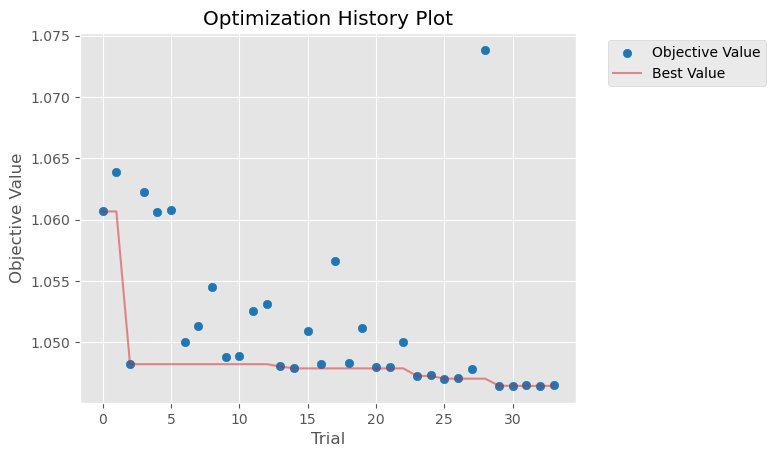

C:\Users\Axyom\AppData\Local\Temp\ipykernel_11192\13775394.py:86: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


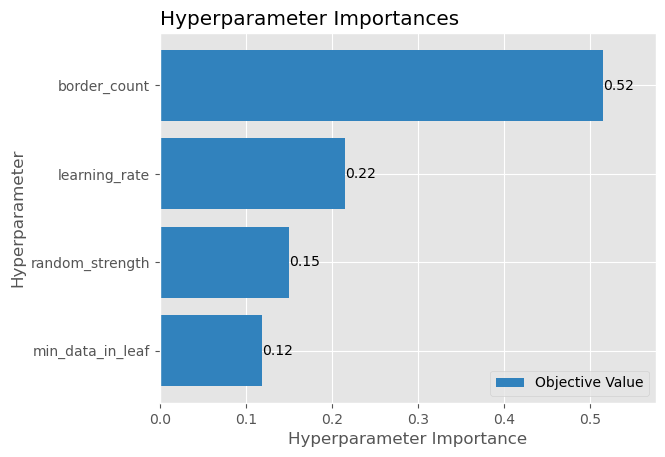

C:\Users\Axyom\AppData\Local\Temp\ipykernel_11192\13775394.py:89: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


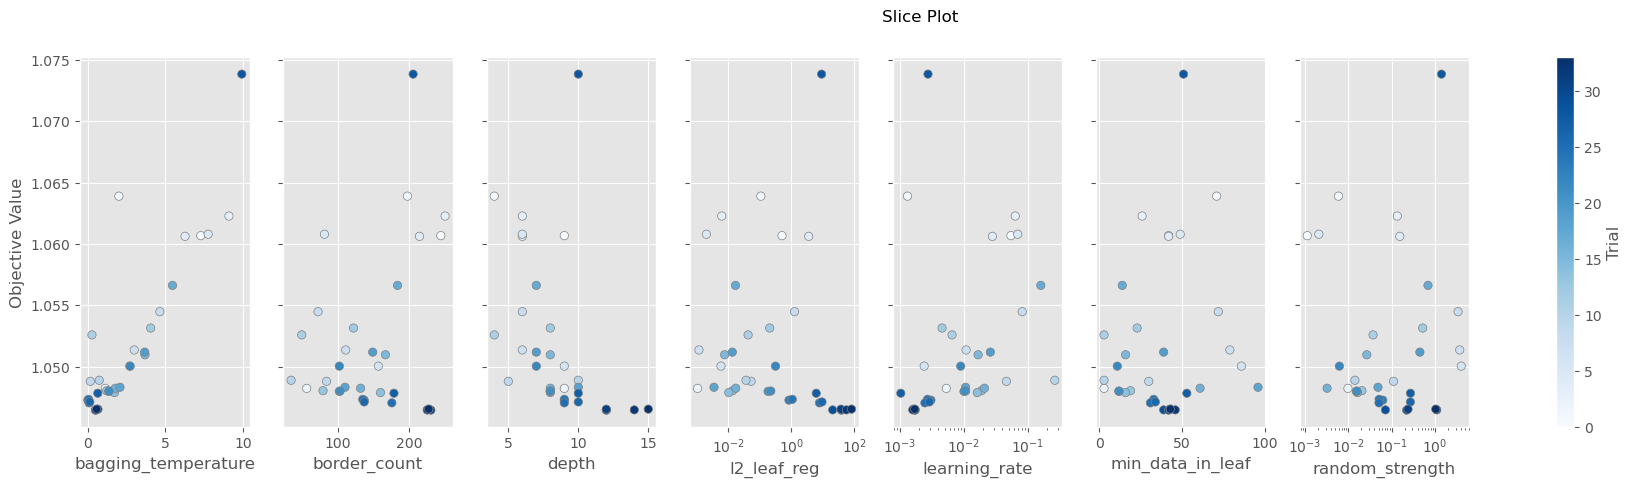

In [6]:
import json
import optuna
from optuna.samplers import TPESampler
from axyom_utilities.wrappers import CatBoostRegressorWrapper
from axyom_utilities.training import train_model_cv
from optuna.visualization.matplotlib import (
    plot_optimization_history, 
    plot_param_importances, 
    plot_parallel_coordinate,
    plot_slice,
    plot_contour
)
import matplotlib.pyplot as plt

if HYPER_OPT:
    fixed_params = {
        "iterations": 10000,
        "task_type": "GPU",
        "verbose": False
    }
    
    # Define the Optuna objective function
    def objective(trial):
        # Define hyperparameter space
        varying_params = {
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "depth": trial.suggest_int("depth", 4, 20),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 100, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 4),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "random_strength": trial.suggest_float("random_strength", 1e-3, 10, log=True),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
            #"grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"])
        }

        cb_params = {**fixed_params, **varying_params}
        
        # Initialize CatBoostRegressor with trial parameters
        model = CatBoostRegressorWrapper(**cb_params)
        
        # Evaluate using K-Fold CV with early stopping
        results = train_model_cv(\
            model, 
            X_train, 
            y_train, 
            X_test, 
            X_orig,
            cv_splits=5, 
            early_stopping_rounds=50
        )
        score = results['cv_scores'].mean()

        trial.set_user_attr("best_iteration", results['best_iteration'])
        
        return score
    
    # Prepare data
    # Replace X_train, y_train, and X_test with your data
    # Example:
    # X_train, X_test, y_train = ...
    
    # Run Optuna optimization
    study = optuna.create_study( \
        direction="minimize", 
        study_name="Catboost_v1", 
        storage="sqlite:///catboost_study_v1.db", 
        load_if_exists=True,
        sampler=TPESampler(seed=666)
    )
    study.optimize(objective, n_trials=100, timeout=3600*5)
    
    # Best parameters and result
    print("Best Trial: ", study.best_trial.params)
    print("Best RMSE: ", study.best_value)

    cb_best_params = {**fixed_params, **study.best_trial.params}

    cb_best_params["iterations"] = study.best_trial.user_attrs.get("best_iteration", None)

    with open("cb_best_params.json", "w") as f:
        json.dump(cb_best_params, f, indent=4)
   
    plot_optimization_history(study)
    plt.show()
    
    plot_param_importances(study)
    plt.show()
    
    plot_slice(study)
    plt.show()

else:
    cb_best_params = {
        'iterations': 6053,
        'task_type': 'GPU',
        'verbose': False,
        'learning_rate': 0.0017206296005747735,
        'depth': 12,
        'l2_leaf_reg': 39.52504100536895,
        'bagging_temperature': 0.4924141191408251,
        'border_count': 231,
        'random_strength': 0.22221831653366686,
        'min_data_in_leaf': 42
    }

In [7]:
cb_best_params

{'iterations': 6053,
 'task_type': 'GPU',
 'verbose': False,
 'learning_rate': 0.0017206296005747735,
 'depth': 12,
 'l2_leaf_reg': 39.52504100536895,
 'bagging_temperature': 0.4924141191408251,
 'border_count': 231,
 'random_strength': 0.22221831653366686,
 'min_data_in_leaf': 42}

In [8]:
cb_best_params["iterations"] = 10000

# Model Training

In [9]:
# Initialize a CatBoost Regressor
model = CatBoostRegressorWrapper(**cb_best_params)

# Use the train_model function to train and evaluate the model
results = train_model_cv(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    X_orig=X_orig,
    early_stopping_rounds=100,
    cv_splits=7
)

Training fold 1...
Fold 1 RMSE: 1.0501
Training fold 2...
Fold 2 RMSE: 1.0435
Training fold 3...
Fold 3 RMSE: 1.0471
Training fold 4...
Fold 4 RMSE: 1.0440
Training fold 5...
Fold 5 RMSE: 1.0476
Training fold 6...
Fold 6 RMSE: 1.0487
Training fold 7...
Fold 7 RMSE: 1.0430
Mean CV RMSE: 1.0463 ± 0.0026


In [10]:
mean_score = np.mean(results["cv_scores"])
std_score = np.std(results["cv_scores"])

# Prepare the data
data = {
    "mean_score": mean_score,
    "std_score": std_score
}

# Save to a JSON file
with open("score.json", "w") as json_file:
    json.dump(data, json_file, indent=4)  # Use `indent` for readability

In [ ]:
import joblib

# Save OOF predictions as a CSV file
oof_preds_df = pd.DataFrame({"oof_preds": results["oof_preds"]})
oof_preds_df.to_csv("oof_preds", index=False)
print("OOF predictions saved to oof_preds.csv.")

test_preds_df = pd.DataFrame({"test_preds": results["test_preds"]})
test_preds_df.to_csv("test_preds", index=False)
print("Test predictions saved to test_preds.csv.")

joblib.dump(results["models"], "models.pkl")

OOF predictions saved to oof_preds.csv.
Test predictions saved to test_preds.csv.


['xgboost_models.pkl']

# Submission

In [ ]:
y_pred = np.expm1(results['test_preds'])

submission = pd.DataFrame({
    'id': X_test.index,  
    'Premium Amount': y_pred
})

FILE_PATH = "Clean_Catboost.csv"

submission.to_csv(FILE_PATH, index=False)

In [ ]:
import os

# Define your message and file paths
COMP_NAME = "playground-series-s4e12"

SUBMIT_MESSAGE = f"Clean Catboost: Mean score: {mean_score:.4f} +/- {std_score:.4f}"

# Submit to Kaggle

if SUBMIT_TO_KAGGLE: 
    os.system(f'kaggle competitions submit -c {COMP_NAME} -f {FILE_PATH} -m "{SUBMIT_MESSAGE}"')

In [ ]:
#os.system(f'kaggle competitions submit -c {COMP_NAME} -f {FILE_PATH} -m "{SUBMIT_MESSAGE}"')

0

In [14]:
# import os
# from IPython.display import display, Javascript

# # Define your message and file paths
# COMP_NAME = "playground-series-s4e12"
# FILE_PATH = "submission.csv"

# SUBMIT_MESSAGE = f"Clean XGB: Mean score: {mean_score:.4f} +/- {std_score:.4f}"

# # Submit to Kaggle
# if SUBMIT_TO_KAGGLE: 
#     os.system(f'kaggle competitions submit -c {COMP_NAME} -f {FILE_PATH} -m "{SUBMIT_MESSAGE}"')

# # Git commit and push
# GIT_COMMIT_MESSAGE = f"Submission: {SUBMIT_MESSAGE}"

# # save notebook
# # display(Javascript('IPython.notebook.save_checkpoint()'))

# # Commands for Git
# os.system("git add .")  # Stage all changes (adjust if you only want specific files)
# os.system(f'git commit -m "{GIT_COMMIT_MESSAGE}"')  # Commit changes with a message
# os.system("git push origin main")  # Push to the main branch (change branch if needed)